# EECS 491 Assigment 4
## Randolph Zhao

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.tokenize import sent_tokenize
import spacy
from sentence_transformers import SentenceTransformer
import re
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from tabulate import tabulate
from sklearn.decomposition import PCA

## Exercise 1. Multivariate Gaussians (10 points)

### 1.1

We have three 2D covariance matrices:
1. $x$ and $y$ are uncorrelated: 
$$
\Sigma_{11}=\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$
$$
\Sigma_{12}=\begin{bmatrix}
0.5 & 0 \\
0 & 0.5
\end{bmatrix}
$$
2. $x$ and $y$ are correlated: 
$$
\Sigma_{21}=\begin{bmatrix}
1 & 0.75 \\
0.75 & 1
\end{bmatrix}
$$
$$
\Sigma_{22}=\begin{bmatrix}
1 & 0.25 \\
0.25 & 1
\end{bmatrix}
$$
3. $x$ and $y$ are anti-correlated: 
$$
\Sigma_{31}=\begin{bmatrix}
1 & -0.75 \\
-0.75 & 1
\end{bmatrix}
$$
$$
\Sigma_{32}=\begin{bmatrix}
1 & -0.25 \\
-0.25 & 1
\end{bmatrix}
$$

For each covraiance matrix, we will plot two distributions with two different means: 
1. $\mu=[0,0]$
2. $\mu=[2,0]$

In [3]:
def plot_mg(covs, title):
    np.random.seed(12345)
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(10,10))
    fig.suptitle(title)
    
    x, y = np.random.multivariate_normal([0,0], covs[0], 1000).T
    ax1.scatter(x, y)
    ax1.title.set_text('cov 0 with mean=[0,0]')
    
    np.random.seed(12345)
    x, y = np.random.multivariate_normal([2,0], covs[0], 1000).T
    ax2.scatter(x, y)
    ax2.title.set_text('cov 0 with mean=[2,0]')
    
    x, y = np.random.multivariate_normal([0,0], covs[1], 1000).T
    ax3.scatter(x, y)
    ax3.title.set_text('cov 1 with mean=[0,0]')
    
    np.random.seed(12345)
    x, y = np.random.multivariate_normal([2,0], covs[1], 1000).T
    ax4.scatter(x, y)
    ax4.title.set_text('cov 1 with mean=[2,0]')

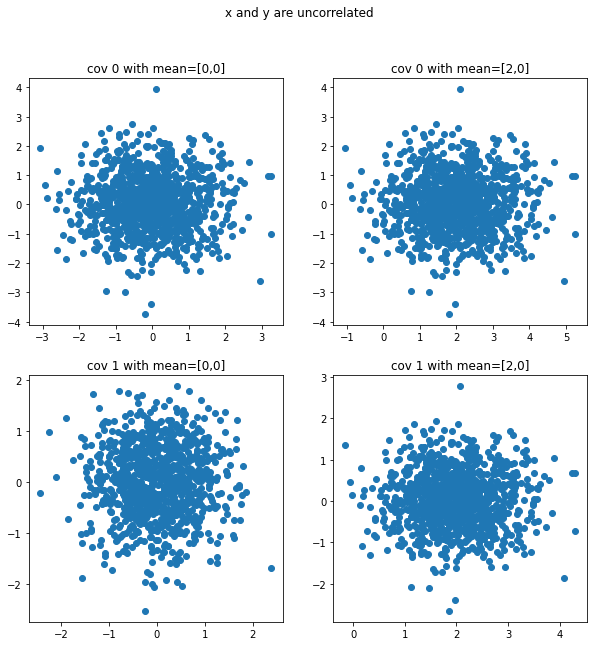

In [4]:
plot_mg([[[1, 0], [0, 1]], [[.5, 0], [0, .5]]], 'x and y are uncorrelated')

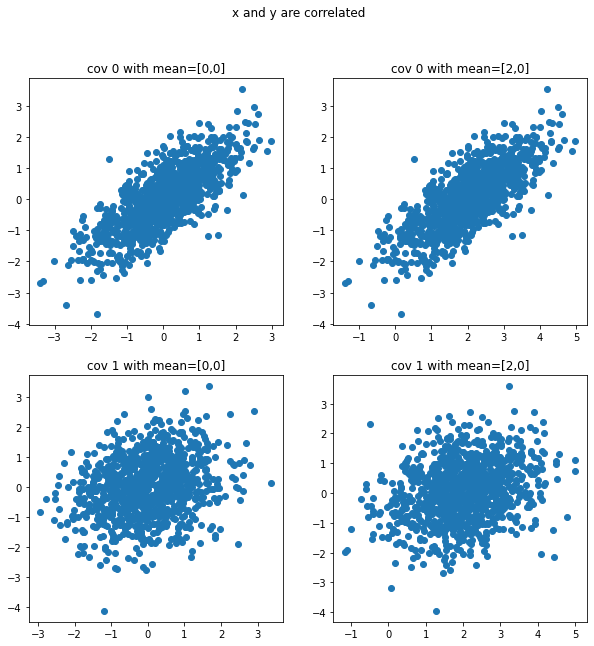

In [5]:
plot_mg([[[1, .75], [.75, 1]], [[1, .25], [.25, 1]]], 'x and y are correlated')

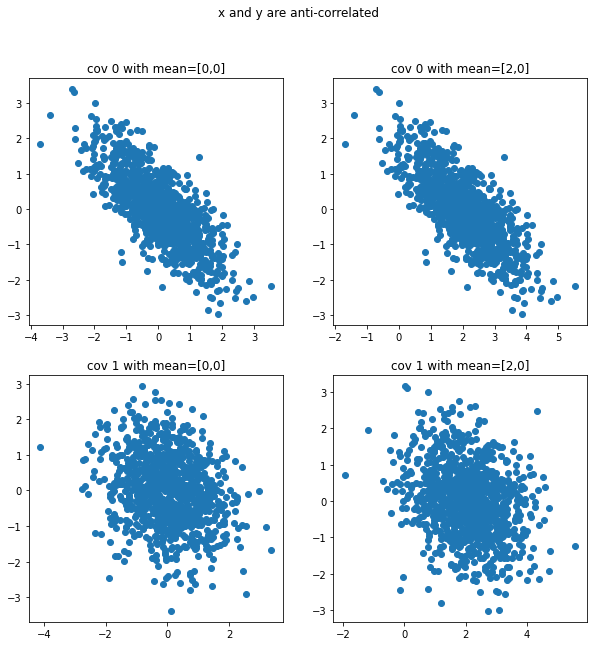

In [6]:
plot_mg([[[1, -.75], [-.75, 1]], [[1, -.25], [-.25, 1]]], 'x and y are anti-correlated')

### 1.2

In [7]:
# The plot of sigma contour refers to https://matplotlib.org/3.2.2/gallery/statistics/confidence_ellipse.html

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [8]:
def plot_mg_more(cov, title):
    np.random.seed(12345)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    fig.suptitle(title)
    
    x, y = np.random.multivariate_normal([0,0], cov, 1000).T
    ax1.scatter(x, y)
    _, v = np.linalg.eig(cov)
    ax1.quiver([0, 0], [0, 0], v[0,:], v[1,:], scale=5)
    confidence_ellipse(x, y, ax1, n_std=1, edgecolor='r', label=r'$1 \sigma$', linewidth=3)
    confidence_ellipse(x, y, ax1, n_std=2, edgecolor='g', label=r'$2 \sigma$', linewidth=3)
    confidence_ellipse(x, y, ax1, n_std=3, edgecolor='b', label=r'$3 \sigma$', linewidth=3)
    ax1.legend()
    
    np.random.seed(12345)
    x, y = np.random.multivariate_normal([2,0], cov, 1000).T
    ax2.scatter(x, y)
    _, v = np.linalg.eig(cov)
    ax2.quiver([2, 2], [0, 0], v[0,:], v[1,:], scale=5)
    confidence_ellipse(x, y, ax2, n_std=1, edgecolor='r', label=r'$1 \sigma$', linewidth=3)
    confidence_ellipse(x, y, ax2, n_std=2, edgecolor='g', label=r'$2 \sigma$', linewidth=3)
    confidence_ellipse(x, y, ax2, n_std=3, edgecolor='b', label=r'$3 \sigma$', linewidth=3)
    ax2.legend()

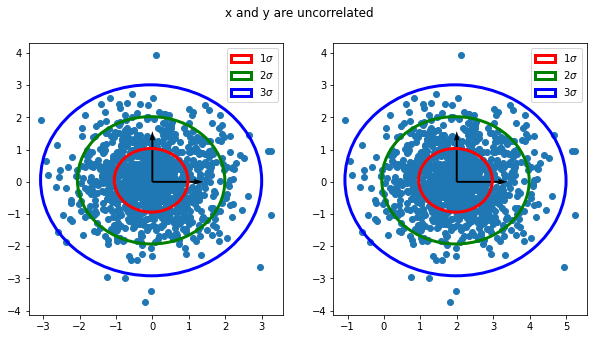

In [9]:
plot_mg_more([[1, 0], [0, 1]], 'x and y are uncorrelated')

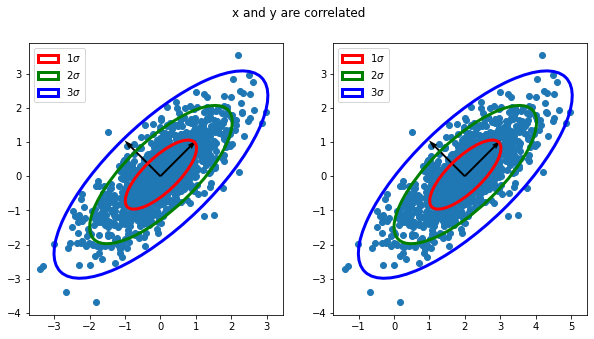

In [10]:
plot_mg_more([[1, .75], [.75, 1]], 'x and y are correlated')

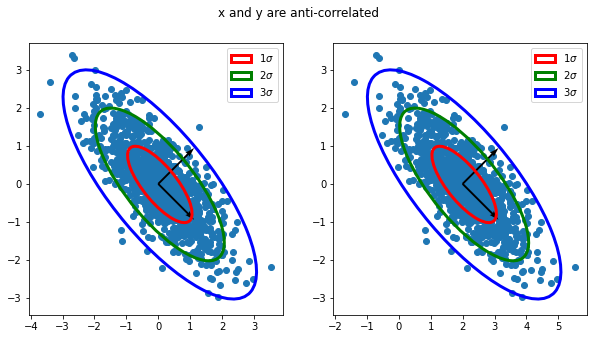

In [11]:
plot_mg_more([[1, -.75], [-.75, 1]], 'x and y are anti-correlated')

## Exercise 2. Linear Gaussian Models (20 pts)

### 2.1

The characteristic function of x and z are 
$$\phi_x(u)=e^{iu^T\mu_x - \frac{1}{2}u^T\Sigma_x u}$$
$$\phi_z(u)=e^{iu^T\mu_z - \frac{1}{2}u^T\Sigma_z u}$$
. Thus, since the characteristic function of the sum of two Gaussian variables is the product of the characteristic functions, we have 
$$\phi_y(u)=\phi_{x+z}(u)=e^{iu^T\mu_x - \frac{1}{2}u^T\Sigma_x u+iu^T\mu_z - \frac{1}{2}u^T\Sigma_z u}$$
$$\phi_y(u)=\phi_{x+z}(u)=e^{iu^T(\mu_x+\mu_z) - \frac{1}{2}u^T(\Sigma_x+\Sigma_z) u}$$

\begin{align} 
p(y)&=N(y|\mu_x+\mu_z, \Sigma_x+\Sigma_z) \\
\end{align}

### 2.2

We know that the conditional of a joint Gaussian is also Guassian, and we have 
$$
y|x\sim N(\mu_y+\Sigma_{yx}\Sigma_{xx}^{-1}(x-\mu_y), \Sigma_{yy}-\Sigma_{yx}\Sigma_{xx}^{-1}\Sigma_{xy})
$$.

We know $\Sigma_{xx}=\Sigma_{x}$ and $\Sigma_{yy}=\Sigma_{y}$. From 2.1, we know $\mu_y=\mu_x+\mu_z$, $\Sigma_y=\Sigma_x+\Sigma_z$, we have
$$
p(y|x)=N(\mu_x+\mu_z+\Sigma_{yx}\Sigma_{x}^{-1}(x-\mu_x-\mu_z), \Sigma_x+\Sigma_z-\Sigma_{yx}\Sigma_{x}^{-1}\Sigma_{xy})
$$.

### 2.3

In [12]:
np.random.seed(12345)

# distribution of x
mean1 = [0,0]
cov1 = [[1,0],[0,1]]
x1, x2 = np.random.multivariate_normal(mean1, cov1, 1000).T

# distribution of z
mean2 = [2,0]
cov2 = [[1,1],[1,1]]
z1, z2 = np.random.multivariate_normal(mean2, cov2, 1000).T

In [13]:
# distribution of y
y1 = x1+z1
y2 = x2+z2
mean3 = [np.mean(y1), np.mean(y2)]
cov3 = np.cov([y1,y2])
print('mean of y: ', mean3)
print('cov of y: ', cov3)

mean of y:  [1.9740483127629362, 0.055566377833485274]
cov of y:  [[1.99922744 0.99583762]
 [0.99583762 2.00590195]]


In [14]:
# distribution of x+z
mean4 = np.add(mean1,mean2)
cov4 = np.add(cov1,cov2)
print('mean of x+z: ', mean4)
print('cov of x+z: ', cov4)

mean of x+z:  [2 0]
cov of x+z:  [[2 1]
 [1 2]]


Let $\mu_x=[0,0], $
$$
\Sigma_x=\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$
,$\mu_z=[2,0], $
$$
\Sigma_z=\begin{bmatrix}
1 & 1 \\
1 & 1
\end{bmatrix}
$$.
Our result of 2.1 shows $y$ should have $\mu_y=[2,0], $
$$
\Sigma_y=\begin{bmatrix}
2 & 1 \\
1 & 2
\end{bmatrix}
$$.
From the above results calculated from the summing sampling of $x$ and $z$, the sampling result is nearly the same as our 2.1 reults. The minor difference is due to the size of sampling.

## Exercise 3. Dimensionality Reduction and PCA (25 pts)

### 3.1

The breast cancer is simple binary classification dataset, which has 30 features. THe following examples show the dataset is a 569*30 datasets, with mean, std, worst of 10 attributes and 569 examples.

In [15]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [16]:
print(cancer.DESCR) 

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

### 3.2

In [17]:
cov = np.cov(df.T)
w, v = np.linalg.eig(cov)
sorted_pair = sorted(((w, v[i]) for i,w in enumerate(w)), reverse=True)
sorted_pair[:2]

[(443782.6051465966,
  array([ 5.08623202e-03,  9.28705650e-03, -1.23425821e-02, -3.42380473e-02,
         -3.54561138e-02, -1.31213101e-01,  3.35131912e-02,  7.54924585e-02,
         -3.50549264e-01, -1.39559852e-01, -4.19346972e-01,  7.35141931e-01,
          2.18087182e-01,  8.10260113e-02,  1.37865559e-01,  1.41957144e-01,
         -4.42129324e-02, -8.97292328e-02,  2.10057742e-02, -8.01074429e-02,
          5.94747777e-02,  8.72363409e-03,  4.57847381e-03,  2.82894830e-02,
         -3.59617411e-03, -1.60336173e-03,  6.48447162e-04,  2.79341068e-03,
         -3.25869730e-03,  5.12865810e-04])),
 (7310.1000616533565,
  array([ 2.19657026e-03, -2.88160658e-03, -6.35497857e-03, -3.62415111e-01,
          4.43187450e-01, -2.13486089e-01, -7.84253475e-01,  6.87405638e-02,
          4.08376429e-03, -7.66679112e-02,  2.90168453e-02, -1.77040388e-03,
          4.23058843e-03,  1.98471260e-03, -7.07543943e-03,  3.71772553e-03,
          1.74411881e-03,  1.41458884e-04,  1.24960485e-03,  2.1

In [18]:
sorted_pair[-1]

(7.019972613496348e-07,
 array([ 1.68928625e-04, -1.75471479e-04, -8.46552237e-04, -1.15618071e-02,
        -6.16530214e-03,  1.04511092e-02,  1.08822097e-02,  5.96017341e-03,
         1.91177497e-01,  1.00411922e-01,  5.92901605e-01,  5.97245084e-01,
        -3.35405153e-01,  9.88608381e-02, -1.29230578e-01, -1.05075524e-01,
         2.69804020e-01, -1.16402570e-02, -2.70708049e-02,  7.59212067e-02,
         9.48178123e-02,  3.33052794e-02,  6.52663643e-02, -1.18303714e-02,
        -2.49243203e-02,  1.62159306e-03,  4.92968092e-03, -6.00223990e-03,
         8.73144088e-03,  1.08953390e-03]))

We can see that compared to the smallest eigenvector, some value of the largest two eigenvectors have 10 times of the smallest eigenvector, which means the data have larger expansion in the direction of the largest two eigenvectors and the largest two eigenvectors contain large linear combination information of each feature. Thus, by using these two eigenvectors, we may capture most of the structure or information of the whole data. 

By looking at more details, we can compare the relativeness of each eigenvector with each feature. For example, the first largest eigenvector has larger first feature 'radius (mean)' than the second largest eigenvector, which means the first largest eigenvector is more related to the first feature (expand more on the dimension of that feature).

### 3.3

In [19]:
variances = []
for i in w:
     variances.append(i/sum(w) * 100)
        
sorted_pair = sorted(((var, i) for i,var in enumerate(variances)), reverse=True)

sorted_pair[:5]

[(98.20446715106618, 0),
 (1.6176489863511032, 1),
 (0.15575107450152373, 2),
 (0.012093196354011787, 3),
 (0.008827245358462058, 4)]

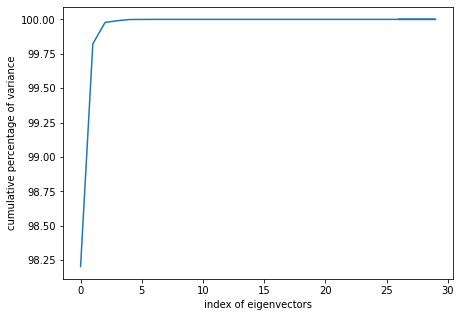

In [20]:
fig = plt.figure(figsize = (7, 5))

plt.plot([pair[1] for pair in sorted_pair], np.cumsum([pair[0] for pair in sorted_pair]))
 
plt.xlabel("index of eigenvectors")
plt.ylabel("cumulative percentage of variance")
plt.show()

We can see the first principal component capture 98.2% of the variance and the first two principal components capture 99.82% of the variance. This means that the first two principal component are very important and carry the most of the information of the whole dataset. The data expands significantly in the direction of the first principal component and a little in the second principal component and a very little in the rest components. Such a higher propotion of the variance shows we can represent the data in a 1D or 2D dimension without losing too much information.

### 3.4

Text(0, 0.5, 'Principal Component 2')

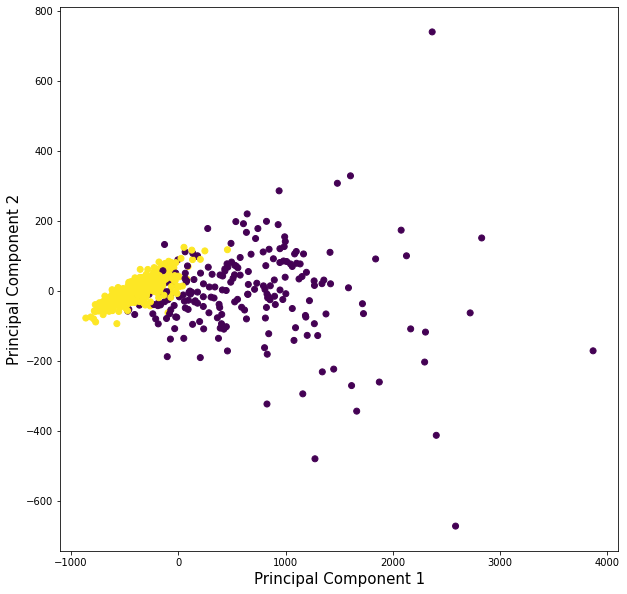

In [21]:
# project the data into the largest two principal components
principalDf = pd.DataFrame(data = PCA(n_components=2).fit_transform(df)
             , columns = ['PC1', 'PC2'])
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
ax1.scatter(principalDf['PC1'], principalDf['PC2'], c=cancer.target)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)

In [22]:
np.cov(principalDf['PC1'], principalDf['PC2'])

array([[4.43782605e+05, 1.63965242e-12],
       [1.63965242e-12, 7.31010006e+03]])

In [23]:
np.cov(principalDf.loc[cancer.target==0]['PC1'], principalDf.loc[cancer.target==0]['PC2'])

array([[478991.26618991,  -5915.80704295],
       [ -5915.80704295,  17372.39917368]])

In [24]:
np.cov(principalDf.loc[cancer.target==1]['PC1'], principalDf.loc[cancer.target==1]['PC2'])

array([[43691.3614855 ,  6097.96578092],
       [ 6097.96578092,  1349.08921217]])

From the graph above, we can see the projected data has a dense cluster at [0,0], and the projected data on PC1,PC2 is close to uncorrelated. The yellow class (class 1: WDBC-Benign) shows a very dense cluster and the principal component 1,2 of yellow class are strongly correlated. By contrast, the purple class (class 0: WDBC-Malignant) ditributes widely and the principal component 1,2 of purple class are slightly anti-correlated. We also can find that the classification between two classes is obvious in the projection of the data on these two largest principle components. We also can see that data on PC1 spread more widely than PC2. This is because the original data expands more in the direction of PC1, which in other words, the orignial data relies more on the direction of PC1. So after the projection on PC1,PC2, the data will have a larger range on the PC1 and mainly distributed on PC1. Compared to PC1, PC2 is less needed for the orignal data so the data does not spread largely on PC2.

## Exercise 4. Gaussian Mixture Models (25 pts)

### 4.1

My multivariate Gaussian mixture model:
1. initialization: randomly shuffle the data and divide the data into K subsets
        initial mean = mean of each subset
        initial cov = cov of each subset
        initial pi = 1/K of K class
2. while the change of log_likelihood is larger than 1e-10:
        E step: evaluate the responsibilities
        M step: update the mean/cov/pi using the responsibilities
        update log_likelihood difference

Predict step:
    calculate the $\pi_k N(x|\mu_k, \Sigma_k)$ for each K and then pick $argmax_k p(x=k)$ as the class label 

Protect of singularity: add a protect matrix = 1e-4 * np.identity(len(data[0])) to each operation of covariance matrix.


In [25]:
class MY_GMM:
    def __init__(self, K, max_iter=100):
        self.K = K
        self.max_iter = max_iter

    def fit(self, data):
        # initialization
        np.random.seed(12345)
        np.random.shuffle(data)
        subsets = np.array_split(data, self.K)
        self.protect = 1e-4 * np.identity(len(data[0]))
        self.means = [np.mean(i, axis=0) for i in subsets]
        self.covs = [np.cov(i.T) for i in subsets]
        self.pis = [1/self.K for _ in range(self.K)]
        diff = 1
        log_likelihood = np.sum(np.log(np.sum(self.pis[k] * 
                        multivariate_normal(self.means[k], self.covs[k] + 
                        self.protect).pdf(data) for k in range(self.K))))
        self.iter = 0
        while diff > 1e-10:
            # E step: evaluate the responsibilities using the current parameter values
            self.gamma = np.zeros((len(data), self.K))
            for pi, mean, cov, k in zip(self.pis, self.means, 
                                        self.covs, range(self.K)):
                cov += self.protect
                mn = multivariate_normal(mean=mean, cov=cov)
                self.gamma[:, k] = pi * mn.pdf(data)
            for n in range(len(data)):
                self.gamma[n, :] = self.gamma[n, :] / np.sum(self.gamma[n, :])
            
            # M step: Re-estimate the parameters using the current responsibilities
            n = np.sum(self.gamma, axis=0)
            self.pis = n/np.sum(n)
            self.means = np.dot(self.gamma.T, data) / n.reshape(self.K, 1)
            self.covs = []
            for k in range(self.K):
                covc = 1/n[k] * (np.dot((self.gamma[:, k].reshape(len(data), 1) *
                            (data-self.means[k]) ).T, data - self.means[k]) +
                            self.protect)
                self.covs.append(covc)
            self.covs = np.asarray(self.covs)
            
            # update the difference of log likelihood
            new_log_likelihood = np.sum(np.log(np.sum(self.pis[k] * 
                        multivariate_normal(self.means[k], self.covs[k] + 
                        self.protect).pdf(data) for k in range(self.K))))
            diff = abs(log_likelihood - new_log_likelihood)
            log_likelihood = new_log_likelihood
            self.iter += 1
            
        return self
    
    def predict(self, test_data):
        labels = np.zeros((test_data.shape[0], self.K))
        
        for k in range(self.K):
            labels[:, k] = self.pis[k] * multivariate_normal.pdf(test_data, 
                                                    self.means[k,:], self.covs[k])
        labels  = labels.argmax(1)
        
        return labels 
    
    def plot_progress(self, data, stop_iters):
        output = [[], [], []]
        fig, axes = plt.subplots(1, len(stop_iters), figsize=(5*len(stop_iters),5))
        # initialization
        subsets = np.array_split(data, self.K)
        self.protect = 1e-6 * np.identity(len(data[0]))
        self.means = [np.mean(i, axis=0) for i in subsets]
        self.covs = [np.cov(i.T) for i in subsets]
        self.pis = [1/self.K for _ in range(self.K)]
        iteration = 0
        ax = axes[stop_iters.index(iteration)]
        ax.scatter(data[:, 0], data[:, 1], s=10)
        ax.set_title(f"iteration {iteration}")
        self.plot_details(data, ax, iteration)
        print(f'iteration: {iteration}')
        print(f'means: {self.means}')
        print(f'covs: {self.covs}')
        print(f'class probabilities: {self.pis}')
        print()
        iteration += 1
        while iteration <= stop_iters[-1]:
            # E step: evaluate the responsibilities using the current parameter values
            self.gamma = np.zeros((len(data), self.K))
            for pi, mean, cov, k in zip(self.pis, self.means, 
                                        self.covs, range(self.K)):
                cov += self.protect
                mn = multivariate_normal(mean=mean, cov=cov)
                self.gamma[:, k] = pi * mn.pdf(data)
            for n in range(len(data)):
                self.gamma[n, :] = self.gamma[n, :] / np.sum(self.gamma[n, :])
            
            # M step: Re-estimate the parameters using the current responsibilities
            n = np.sum(self.gamma, axis=0)
            self.pis = n/np.sum(n)
            self.means = np.dot(self.gamma.T, data) / n.reshape(self.K, 1)
            self.covs = []
            for k in range(self.K):
                covc = 1/n[k] * (np.dot((self.gamma[:, k].reshape(len(data), 1) *
                            (data-self.means[k]) ).T, data - self.means[k]) + 
                            self.protect)
                self.covs.append(covc)
            self.covs = np.asarray(self.covs)
            
            # if needed to plot the status, plot the 3 sigma contour
            if iteration in stop_iters:
                ax = axes[stop_iters.index(iteration)]
                self.plot_details(data, ax, iteration)
                print(f'iteration: {iteration}')
                print(f'means: {self.means}')
                print(f'covs: {self.covs}')
                print(f'class probabilities: {self.pis}')
                print()
            iteration += 1

    def plot_details(self, data, ax, iteration):
        ax.scatter(data[:, 0], data[:, 1], s=10, edgecolor='b')
        ax.set_title(f"iteration {iteration}")
        for mean, cov, i in zip(self.means, self.covs, range(self.K)):
            cov += self.protect
            ax.scatter(mean[0], mean[1], marker='o', s=150, label='Centroid '+str(i+1))
            for sigma in [1.0, 2.0, 3.0]:
                pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
                ell_radius_x = np.sqrt(1 + pearson)
                ell_radius_y = np.sqrt(1 - pearson)
                ellipse = Ellipse((0, 0),
                    width=ell_radius_x * 2,
                    height=ell_radius_y * 2,
                    facecolor='none', 
                    edgecolor='r', 
                    linewidth=.5)
                scale_x = np.sqrt(cov[0, 0]) * sigma
                scale_y = np.sqrt(cov[1, 1]) * sigma
                transf = transforms.Affine2D() \
                    .rotate_deg(45) \
                    .scale(scale_x, scale_y) \
                    .translate(mean[0], mean[1])
                ellipse.set_transform(transf + ax.transData)
                ax.add_patch(ellipse)
        ax.legend()

### 4.2

(The code is written as a function of the class MY_GMM above: plot_progress with helper function plot_details)

The example of contour part is using the 4.3 training dataset, where it clusters two Gaussian distribution and plots corresponding 1,2,3 sigma contour and shows the two centroid or mean with two large points.

iteration: 0
means: [array([2.46028207, 0.02636823]), array([2.52512432, 0.02888807])]
covs: [array([[7.38648341, 0.47011096],
       [0.47011096, 0.98707176]]), array([[7.36512249, 0.49456381],
       [0.49456381, 0.9862092 ]])]
class probabilities: [0.5, 0.5]

iteration: 15
means: [[ 0.76043454  0.05995546]
 [ 4.23865161 -0.00495445]]
covs: [[[ 3.94221468 -0.53743976]
  [-0.53743976  0.92163936]]

 [[ 4.75803465  1.62306938]
  [ 1.62306938  1.0490005 ]]]
class probabilities: [0.50196649 0.49803351]

iteration: 100
means: [[-0.02709609  0.03209504]
 [ 5.02314241  0.02314241]]
covs: [[[1.01240281 0.00782906]
  [0.00782906 0.99110687]]

 [[0.9810775  0.9810765 ]
  [0.9810765  0.9810775 ]]]
class probabilities: [0.50105341 0.49894659]



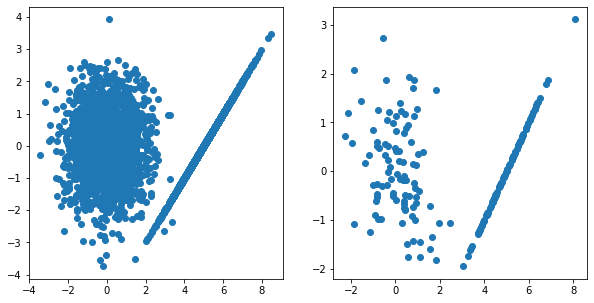

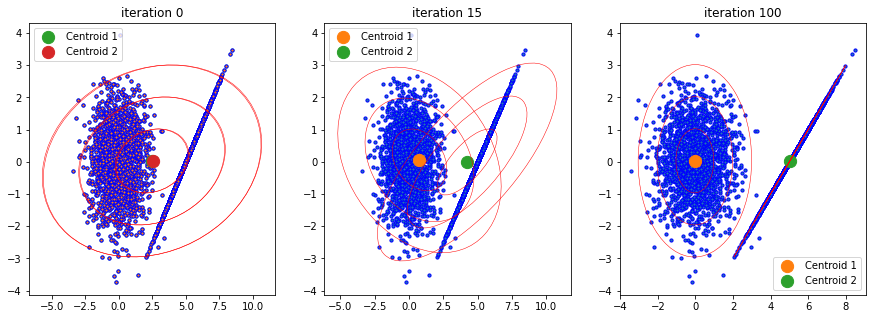

In [26]:
np.random.seed(12345)

mean1 = [0,0]
cov1 = [[1,0],[0,1]]
c1_x, c1_y = np.random.multivariate_normal(mean1, cov1, 2000).T

mean2 = [5,0]
cov2 = [[1,1],[1,1]]
c2_x, c2_y = np.random.multivariate_normal(mean2, cov2, 2000).T

xs = np.concatenate((c1_x, c2_x))
ys = np.concatenate((c1_y, c2_y))

test_data = np.array([np.array([xs[i], ys[i]]) for i in range(len(xs))])
np.random.seed(12345)
np.random.shuffle(test_data)
X_train = test_data[:int(0.95*len(test_data)),]
X_test = test_data[int(0.95*len(test_data)):,]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.scatter(X_train[:,0], X_train[:,1])
ax2.scatter(X_test[:,0], X_test[:,1])

MY_GMM(2).plot_progress(X_train, [0, 15, 100])

### 4.3

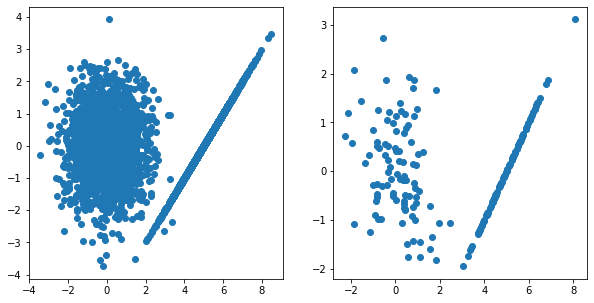

In [27]:
np.random.seed(12345)

mean1 = [0,0]
cov1 = [[1,0],[0,1]]
c1_x, c1_y = np.random.multivariate_normal(mean1, cov1, 2000).T

mean2 = [5,0]
cov2 = [[1,1],[1,1]]
c2_x, c2_y = np.random.multivariate_normal(mean2, cov2, 2000).T

xs = np.concatenate((c1_x, c2_x))
ys = np.concatenate((c1_y, c2_y))

test_data = np.array([np.array([xs[i], ys[i]]) for i in range(len(xs))])
np.random.seed(12345)
np.random.shuffle(test_data)
X_train = test_data[:int(0.95*len(test_data)),]
X_test = test_data[int(0.95*len(test_data)):,]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.scatter(X_train[:,0], X_train[:,1])
ax2.scatter(X_test[:,0], X_test[:,1])

iteration: 0
means: [array([2.46028207, 0.02636823]), array([2.52512432, 0.02888807])]
covs: [array([[7.38648341, 0.47011096],
       [0.47011096, 0.98707176]]), array([[7.36512249, 0.49456381],
       [0.49456381, 0.9862092 ]])]
class probabilities: [0.5, 0.5]

iteration: 15
means: [[ 0.76043454  0.05995546]
 [ 4.23865161 -0.00495445]]
covs: [[[ 3.94221468 -0.53743976]
  [-0.53743976  0.92163936]]

 [[ 4.75803465  1.62306938]
  [ 1.62306938  1.0490005 ]]]
class probabilities: [0.50196649 0.49803351]

iteration: 30
means: [[-0.02709609  0.03209504]
 [ 5.02314241  0.02314241]]
covs: [[[1.01240281 0.00782906]
  [0.00782906 0.99110687]]

 [[0.9810775  0.9810765 ]
  [0.9810765  0.9810775 ]]]
class probabilities: [0.50105341 0.49894659]



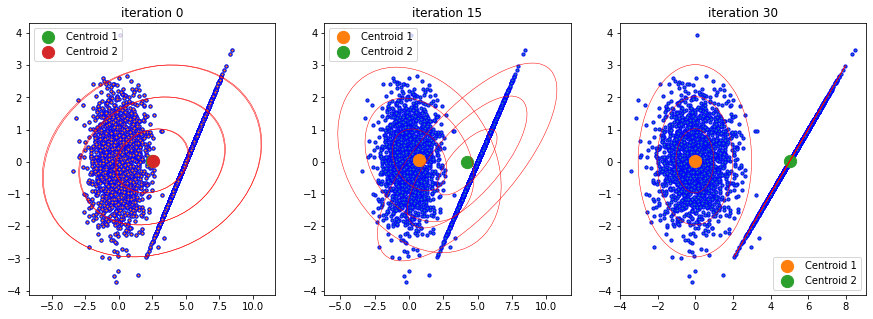

In [28]:
MY_GMM(2).plot_progress(X_train, [0, 15, 30])

<ipython-input-25-d8a9163484e8>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.pis[k] *
<ipython-input-25-d8a9163484e8>:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_log_likelihood = np.sum(np.log(np.sum(self.pis[k] *


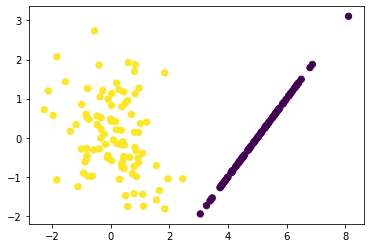

In [29]:
my_gmm = MY_GMM(2).fit(X_train)
labels = my_gmm.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=labels, s=40, cmap='viridis')

Lets put two Gaussian distributions into one test dataset, where $\mu_1 = [0,0], \mu_2 = [0,0]$ and $cov_1 = [[1,0],[0,1]], cov_2 = [[1,1],[1,1]]$ and each distribution is sampled 2000 points. The train set is 95% of the whole set and the test set is 5% of the whole set. Since these two distribution is Gaussian and is very distinguish to each other, the classification with K=2 should be very easy and very accurate. As the result graph shows, the my_gmm model successfully capture two Gaussian distributions very precisely and classify the data in the test set as desired. This verifies my GMM model is working as desired.

### 4.4

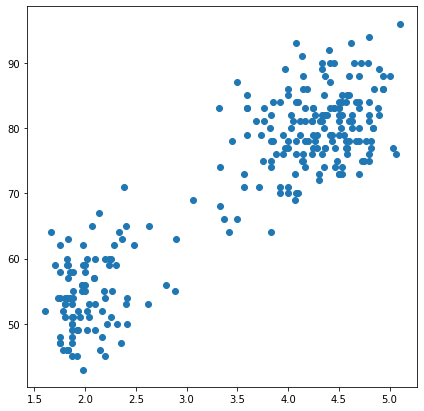

In [30]:
xs = []
ys = []
data = []
with open('./faithful.txt') as f:
    lines = f.readlines()
for line in lines:
    [x, y] = line[:-2].split(' ')
    xs.append(float(x))
    ys.append(float(y))
    data.append(np.array([float(x), float(y)]))
data = np.array(data)

plt.figure(figsize=(7,7))
plt.scatter(xs, ys)
plt.show()

run for 2 iterations


<ipython-input-25-d8a9163484e8>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.pis[k] *
<ipython-input-25-d8a9163484e8>:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_log_likelihood = np.sum(np.log(np.sum(self.pis[k] *


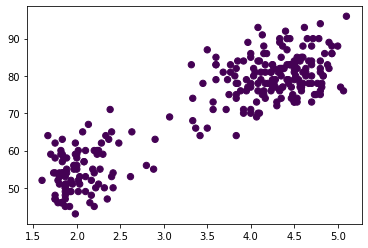

In [31]:
my_gmm = MY_GMM(1).fit(data)
labels = my_gmm.predict(data)
print(f'run for {my_gmm.iter} iterations')
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')

iteration: 0
means: [array([ 3.48778309, 70.89705882])]
covs: [array([[  1.30272933,  13.97780785],
       [ 13.97780785, 184.82331335]])]
class probabilities: [1.0]

iteration: 1
means: [[ 3.48778309 70.89705882]]
covs: [[[  1.29793989  13.92641885]
  [ 13.92641885 184.14381588]]]
class probabilities: [1.]

iteration: 2
means: [[ 3.48778309 70.89705882]]
covs: [[[  1.29793989  13.92641885]
  [ 13.92641885 184.14381588]]]
class probabilities: [1.]



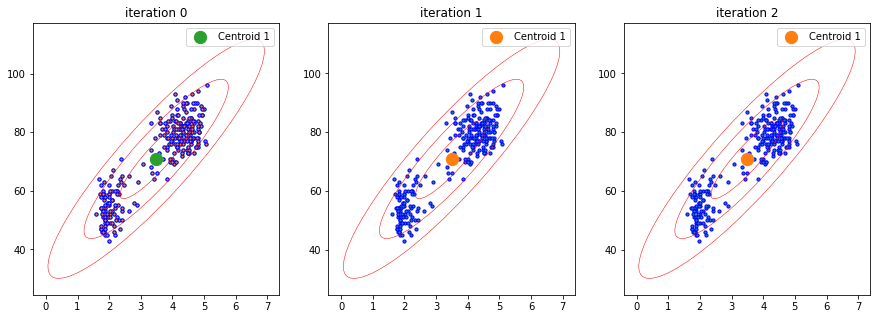

In [32]:
MY_GMM(1).plot_progress(data, [0, 1, 2])

run for 35 iterations


<ipython-input-25-d8a9163484e8>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.pis[k] *
<ipython-input-25-d8a9163484e8>:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_log_likelihood = np.sum(np.log(np.sum(self.pis[k] *


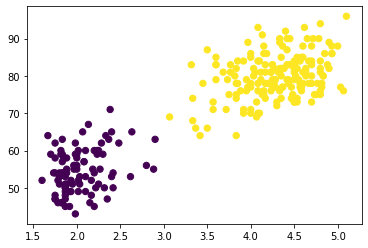

In [33]:
my_gmm = MY_GMM(2).fit(data)
labels = my_gmm.predict(data)
print(f'run for {my_gmm.iter} iterations')
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')

iteration: 0
means: [array([ 3.41372059, 70.42647059]), array([ 3.56184559, 71.36764706])]
covs: [array([[  1.34568006,  14.91902375],
       [ 14.91902375, 201.77233215]]), array([[  1.25837667,  13.06990904],
       [ 13.06990904, 168.79716876]])]
class probabilities: [0.5, 0.5]

iteration: 17
means: [[ 2.3337504  58.37837033]
 [ 4.37252393 80.49452955]]
covs: [[[  0.48768528   5.96366914]
  [  5.96366914 108.4005434 ]]

 [[  0.11533658   0.46400326]
  [  0.46400326  29.95331494]]]
class probabilities: [0.43395739 0.56604261]

iteration: 35
means: [[ 2.03638856 54.47851738]
 [ 4.28966206 79.96811628]]
covs: [[[ 0.06916877  0.43516848]
  [ 0.43516848 33.69728858]]

 [[ 0.16996933  0.94060786]
  [ 0.94060786 36.04619552]]]
class probabilities: [0.3558729 0.6441271]



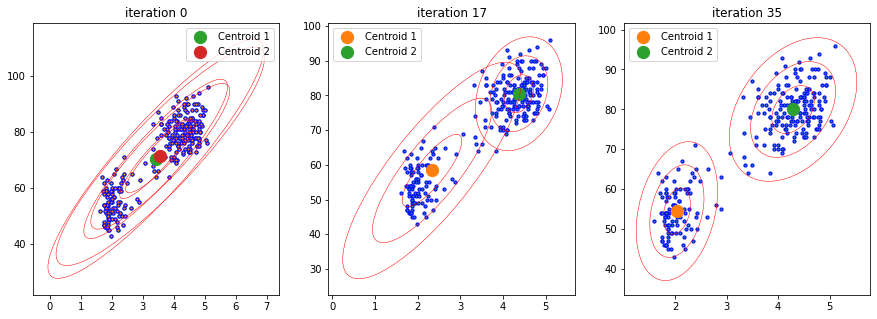

In [34]:
MY_GMM(2).plot_progress(data, [0, 17, 35])

<ipython-input-25-d8a9163484e8>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  log_likelihood = np.sum(np.log(np.sum(self.pis[k] *
<ipython-input-25-d8a9163484e8>:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  new_log_likelihood = np.sum(np.log(np.sum(self.pis[k] *


run for 249 iterations


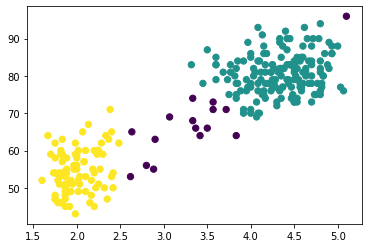

In [35]:
my_gmm = MY_GMM(3).fit(data)
labels = my_gmm.predict(data)
print(f'run for {my_gmm.iter} iterations')
plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')

iteration: 0
means: [array([ 3.56394505, 70.91208791]), array([ 3.50581319, 71.45054945]), array([ 3.39254444, 70.32222222])]
covs: [array([[  1.26311814,  13.82512845],
       [ 13.82512845, 188.28107548]]), array([[  1.30483382,  12.97211844],
       [ 12.97211844, 162.05030625]]), array([[  1.35449655,  15.39656417],
       [ 15.39656417, 207.86129938]])]
class probabilities: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

iteration: 124
means: [[ 3.56786439 70.25588674]
 [ 4.33533061 80.52271491]
 [ 1.99664414 54.38294833]]
covs: [[[5.53614225e-01 7.84959478e+00]
  [7.84959478e+00 1.34873636e+02]]

 [[1.35940135e-01 3.58299057e-01]
  [3.58299057e-01 2.85894247e+01]]

 [[4.39026131e-02 3.44053945e-01]
  [3.44053945e-01 3.37411393e+01]]]
class probabilities: [0.09031445 0.57692002 0.33276552]

iteration: 249
means: [[ 3.5683095  70.26262109]
 [ 4.33533861 80.52271662]
 [ 1.9966484  54.38288731]]
covs: [[[5.53595368e-01 7.84942207e+00]
  [7.84942207e+00 1.34876850e+02]]


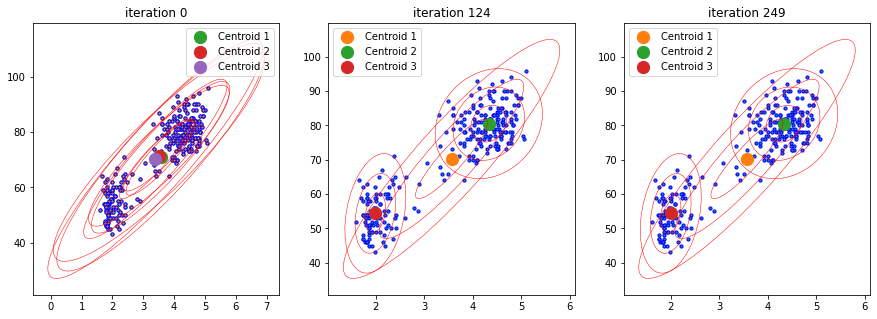

In [36]:
MY_GMM(3).plot_progress(data, [0, 124, 249])

## Exploration (20 points)

In this exploration, I want to explore some applications of Gasussian mixture model such as text summarization. Basically, there are two main categories in text summarization algorithms: abstractive or extractive. In this assignment, I will explore further in the extractive text summarization, which is simply to analyze each sentence and extract directly some 'important' sentences and form a complete summary. Although the text summarization is less flexible and the resulting summary is not fluent between sentences, it is much easier to be implemented.

There are several papers about the text summarization using k-means and TF-IDF. The common idea is 
1. use TF-IDF to form a sentence vector,
2. use k-means by calculating cosine similarity between sentence vectors to cluster,
3. pick one or more closest sentence(s) in each cluster to form a summary.
The logic behind it is that each sentence in the same cluster contains similar information and different clusters contain different information. Thus, by picking one sentence from each cluster, the summary conveys 'each different information'.

Recently, there are many pre-trained NLP models which can be used to embed a sentence to a vector semantically, such as BERT and its variants. Thus, the text summarization by clustering sentences changes to embed sentence to get vector directly. 

Compared to k-means, Gaussian mixture model is more general and needs less property to describe the data but more sensitive and needs more training data.

Thus, it will be interesting to test the performance of text summarization by clustering using Gaussian mixture model. Here's my algorithm:
1. preprocess the text
2. embed the sentence with pre-trained model SBERT
3. use GMM to cluster the sentences into sqrt(# sentences) cluster
4. for each cluster, pick the closest sentence to the mean of each cluster
5. form the complete summary

Here is the tested text summary (by human):

"
Ken thinks that creativity is as important in education as Literacy. However, children are being taught how not to be wrong. Ken argues that being creative means that you have to be willing to be wrong, and the education system treats being wrong as the worst thing possible. In doing this, education teaches away children’s natural urge to ‘give it a go’.

All education systems globally have a ‘hierarchy’, with math and language at the top, social sciences in the middle and arts at the bottom. This is because the childhood education system was developed to satisfy the industrial revolution of the 19th century, where math and science was essential for jobs, but times have changed. While once people just needed school for a good job, then a bachelor degree, and now that alone is no guarantee for a job. Degrees have had a form of inflation over time, and this shows it is shifting too quickly. Having children go to school just to attend university is not really equipping them to work any more.

We know 3 things about intelligence

It is diverse – we think in many ways – visually, in sound, movement, abstract
it is dynamic – original ideas come about from the interaction of many different ways of seeing things.
it is distinct – people have their way of doing things – Ken’s example is a ‘problem student’ who couldn’t sit still at school, but when moved to a dance school fit in fine – she needed to move to think. Her dance skills went on to give her immense fame and fortune, bringing value to millions of people. In modern times, she would probably have been given ADHD medication and been put told to calm down.
We need to redefine our education system – our current way is one of ‘strip mining’ our children for the most desired properties, in the same way we mined the Earth for ore. We now need to use our imaginations and creativity wisely, to face an uncertain and problematic future. We may not see this future, but need to equip our children to conquer it.
"

In [37]:
text = pd.read_csv('./TED.csv')['texts'][0]

# preprocessing and embedding
nlp = spacy.load("en_core_web_sm")
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
raw_sents = []
cleaned_sents = []
for sent in sent_tokenize(text):
    raw_sents.append(sent)
    token_list = []
    for token in nlp(sent):
        word = re.sub('[\W]+', ' ', token.lemma_.lower())
        if word != ' ':
            token_list.append(word)
    sent = ' '.join(token_list)
    cleaned_sents.append(sent)
embedded_sents = sbert_model.encode(cleaned_sents)

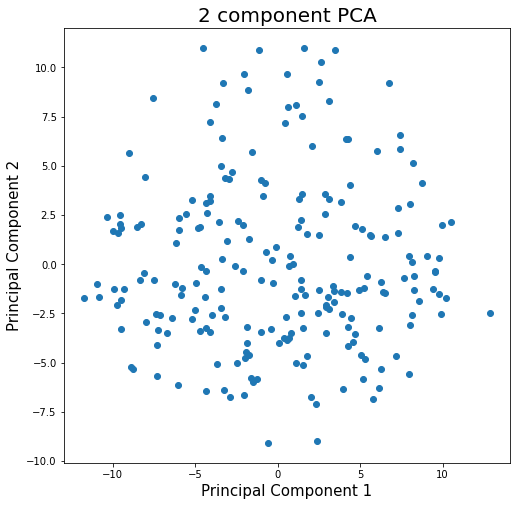

In [38]:
# the original PCA 2-dimension distribution of sentence vector
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embedded_sents)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalComponents[:,0], principalComponents[:,1])

In [39]:
pca.explained_variance_ratio_

array([0.17608047, 0.10441665], dtype=float32)

From the 2-component PCA, we cannot recognize any pattern of distribution in these sentence vectors. This probably because the sentence vectors have very high dimensions and also the data seperate the direction and information in each component (these two principle component only have 17.8% and 10.4% variance). 

In [40]:
# clustering
K = int(len(embedded_sents)**(.5))
gmm = GaussianMixture(n_components=K).fit(embedded_sents)
labels = gmm.predict(embedded_sents)

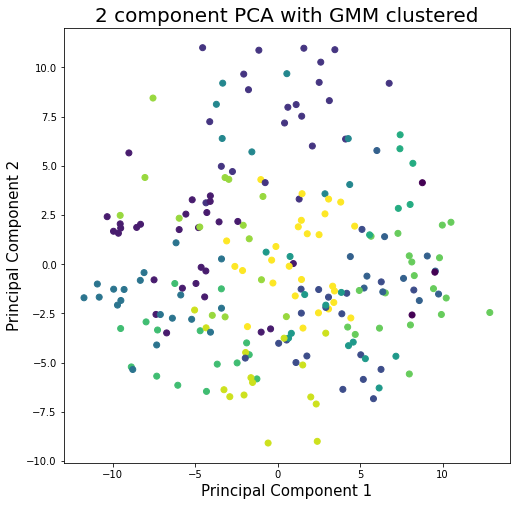

In [41]:
# the GMM-clustered PCA 2-dimension distribution of sentence vector
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA with GMM clustered', fontsize = 20)
ax.scatter(principalComponents[:,0], principalComponents[:,1], c=labels)

From the 2 component PCA, since the projected data is distributed widely, we cannot see the clear cluster, even colored by the labels of GMM clustered results.

In [42]:
from scipy.spatial import distance

def closest_index(node, nodes):
    return distance.cdist([node], nodes).argmin()

selected_index = []
for k in range(K):
    idx = np.where(labels == k)[0]
    selected_index.append(idx[closest_index(gmm.means_[k], [embedded_sents[i] for i in idx])])
summary_gmm = ' '.join([raw_sents[i] for i in selected_index])

# the result summary
summary_gmm

'Anyway, Gillian and I had lunch one day and I said, "How did you get to be a dancer?" "I said, "What happened?" What we do know is, if you\'re not prepared to be wrong, you\'ll never come up with anything original — if you\'re not prepared to be wrong. I think you\'d have to conclude, if you look at the output, who really succeeds by this, who does everything that they should, who gets all the brownie points, who are the winners — I think you\'d have to conclude the whole purpose of public education throughout the world is to produce university professors. Nobody has a clue, despite all the expertise that\'s been on parade for the past four days, what the world will look like in five years\' time. Is that right? She couldn\'t concentrate; she was fidgeting. She eventually graduated from the Royal Ballet School, founded the Gillian Lynne Dance Company, met Andrew Lloyd Webber. If I\'m cooking, the door is shut, the kids are out, the phone\'s on the hook, if she comes in I get annoyed. 

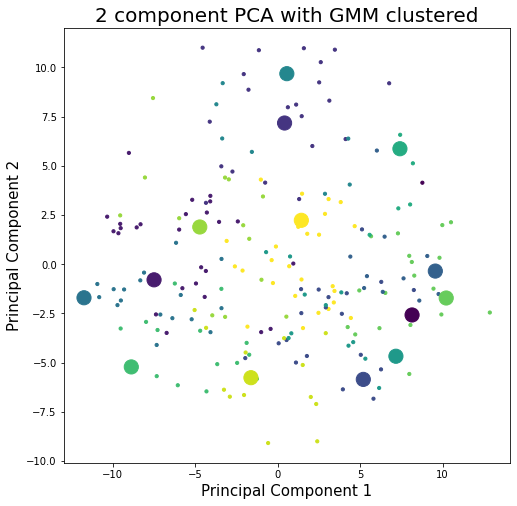

In [43]:
# the selected sentence vector distribution in the GMM-clustered PCA 2-dimension distribution
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA with GMM clustered', fontsize = 20)
ax.scatter(principalComponents[:,0], principalComponents[:,1], c=labels, s=10)
selected_pc = np.array([principalComponents[i,:] for i in selected_index])

selected_pc_label = np.array([labels[i] for i in selected_index])
ax.scatter(selected_pc[:,0], selected_pc[:,1], marker='o', s=200, c=selected_pc_label)

How about the summary of the same text generated by k-means instead?

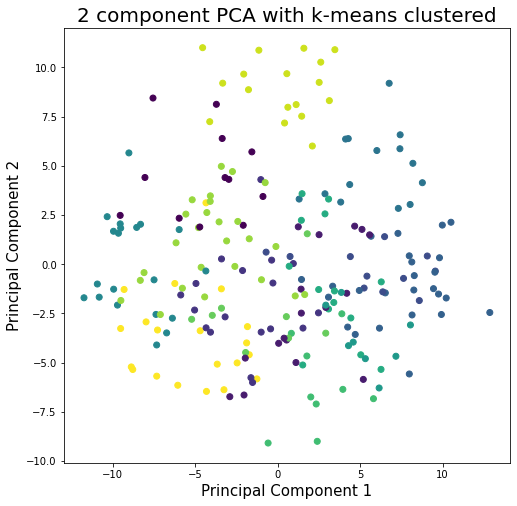

In [44]:
kmeans = KMeans(n_clusters=K).fit(embedded_sents)
labels_2 = kmeans.labels_
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA with k-means clustered', fontsize = 20)
ax.scatter(principalComponents[:,0], principalComponents[:,1], c=labels_2)

In [45]:
from sklearn.metrics import pairwise_distances_argmin_min

avg = []
for j in range(K):
    idx = np.where(kmeans.labels_ == j)[0]
    avg.append(np.mean(idx))
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, embedded_sents)
ordering = sorted(range(K), key=lambda k: avg[k])
summary_kmeans = ' '.join([raw_sents[closest[idx]] for idx in ordering])
summary_kmeans

'He\'d known her for a month.Mind you, they\'d had their fourth anniversary, because it\'s a long time when you\'re 16. I find this very interesting. And then we focus on their heads. Was that wrong?" If they don\'t know, they\'ll have a go. We have a huge vested interest in it, partly because it\'s education that\'s meant to take us into this future that we can\'t grasp. Because it\'s one of those things that goes deep with people, am I right? If you think of it, the whole system of public education around the world is a protracted process of university entrance. Isn\'t it? And I didn\'t want one, frankly. So you were probably steered benignly away from things at school when you were a kid, things you liked, on the grounds that you would never get a job doing that. Following off from Helen yesterday, this is probably why women are better at multi-tasking. And they watched for a few minutes and he turned to her mother and said, "Mrs. Lynne, Gillian isn\'t sick; she\'s a dancer. She eve

We can see by providing the same sentence vectors, k-means and GMM provides similar clusters with some difference in assigning the class in some sentences. From the summary, we also can see that because of the difference of some sentence cluster, the mean or center of some cluster is changed and thus result in different selection of sentences.

We also can see that the second half of the two summaries are similar and all catch the important concept of creativity and the example the presenter provided. Personally, I appreciate the GMM summary more because it also catch the another important point-education-in the first half of the summary. 

However, by comparing with the summary generated by human, we can see that algorithms by simply clustering sentences does not capture the center meaning of the text. Although the embedding model is 'semantics', the summarization model itself is not 'semantics'. In other words, it does not understand the meaning of text. Thus, I do not apperiate the future of extractive text summarization methods. In the future, it may capture the relationship between sentences correctly but it is hard to understand the meaning and generate the summary contained these segmented information which may be distributed in each sentence.